#FloPy3

##Simple water-table solution with recharge

This problem is an unconfined system with a uniform recharge rate, a horizontal bottom, and flow between constant-head boundaries in column 1 and 100. MODFLOW models cannot match the analytical solution exactly because they do not allow recharge to constant-head cells. Constant-head cells in column 1 and 100 were made very thin (0.1 m) in the direction of flow to minimize the effect of recharge applied to them. The analytical solution for this problem can be written as:

$h = \sqrt{b_{1}^{2} - \frac{x}{L} (b_{1}^{2} - b_{2}^{2}) + (\frac{R x}{K}(L-x))} + z_{bottom}$

where $R$ is the recharge rate, $K$ is the the hydraulic conductivity in the horizontal direction, $b_1$ is the specified saturated thickness at the left boundary, $b_2$ is the specified saturated thickness at the right boundary, $x$ is the distance from the left boundary $L$ is the length of the model domain, and $z_{bottom}$ is the elebation of the bottom of the aquifer.

The model consistes of a grid of 100 columns, 1 row, and 1 layer; a bottom altitude of 0 m; constant heads of 20 and 11m in column 1 and 100, respectively; a recharge rate of 0.001 m/d; and a horizontal hydraulic conductivity of 50 m/d.  The discretization is 0.1 m in the row direction for the constant-head cells (column 1 and 100) and 50 m for all other cells.

In [1]:
%matplotlib inline
import sys
import os
import platform
import numpy as np
import matplotlib.pyplot as plt

import flopy
import flopy.utils as fputl

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mfnwt'
if platform.system() == 'Windows':
    exe_name = 'MODFLOW-NWT.exe'
mfexe = exe_name

modelpth = os.path.join('data')
modelname = 'watertable'

#make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.makedirs(modelpth)

###Function to calculate the analytical solution at specified points in a aquifer

In [2]:
def analyticalWaterTableSolution(h1, h2, z, R, K, L, x):
    h = np.zeros((x.shape[0]), np.float)
    #dx = x[1] - x[0]
    #x -= dx
    b1 = h1 - z
    b2 = h2 - z
    h = np.sqrt(b1**2 - (x/L)*(b1**2 - b2**2) + (R * x / K) * (L - x)) + z
    return h

##Model data required to create the model files and calculate the analytical solution

In [3]:
#--model dimensions
nlay, nrow, ncol = 1, 1, 100

#--cell spacing
delr = 50.
delc = 1.

#--domain length
L = 5000.

#--boundary heads
h1 = 20.
h2 = 11.

#--ibound
ibound = np.ones((nlay, nrow, ncol), dtype=np.int)

#--starting heads
strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
strt[0, 0, 0] = h1
strt[0, 0, -1] = h2

#--top of the aquifer
top = 25.

#--bottom of the aquifer
botm = 0.

#--hydraulic conductivity
hk = 50.

#--location of cell centroids
x = np.arange(0.0, L, delr) + (delr / 2.)

#--location of cell edges
xa = np.arange(0, L+delr, delr)

#--recharge rate
rchrate = 0.001

#--calculate the head at the cell centroids using the analytical solution function
hac = analyticalWaterTableSolution(h1, h2, botm, rchrate, hk, L, x)

#--calculate the head at the cell edges using the analytical solution function
ha = analyticalWaterTableSolution(h1, h2, botm, rchrate, hk, L, xa)

#--ghbs
#--ghb conductance
b1, b2 = 0.5*(h1+hac[0]), 0.5*(h2+hac[-1])
c1, c2 = hk*b1*delc/(0.5*delr), hk*b2*delc/(0.5*delr)
#--dtype
ghb_dtype = flopy.modflow.ModflowGhb.get_default_dtype()
print ghb_dtype
#--build ghb recarray
stress_period_data = np.zeros((2), dtype=ghb_dtype)
stress_period_data = stress_period_data.view(np.recarray)
print 'stress_period_data: ', stress_period_data
print 'type is: ', type(stress_period_data)
#--fill ghb recarray
stress_period_data[0] = (0, 0, 0, h1, c1)
stress_period_data[1] = (0, 0, ncol-1, h2, c2)

[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('bhead', '<f4'), ('cond', '<f4')]
stress_period_data:  [(0, 0, 0, 0.0, 0.0) (0, 0, 0, 0.0, 0.0)]
type is:  <class 'numpy.core.records.recarray'>


###Create a flopy object to create and run the MODFLOW-NWT datasets for this problem

In [4]:
mf = flopy.modflow.Modflow(modelname=modelname, exe_name=mfexe, model_ws=modelpth, version='mfnwt')
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, 
                               delr=delr, delc=delc, 
                               top=top, botm=botm, 
                               perlen=1, nstp=1, steady=True)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowUpw(mf, hk=hk, laytyp=1)
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)
rch = flopy.modflow.ModflowRch(mf, rech=rchrate, nrchop=1)
oc = flopy.modflow.ModflowOc(mf)
nwt = flopy.modflow.ModflowNwt(mf, linmeth=2, iprnwt=1, options='COMPLEX')
mf.write_input()

#--remove existing heads results, if necessary
try:
    os.remove(os.path.join(model_ws, '{0}.hds'.format(modelname)))
except:
    pass
#--run existing model
mf.run_model()

FloPy is using the following executable to run the model: /Users/jdhughes/Documents/Development/bin/mac/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: watertable.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/03/08 15:37:40

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/03/08 15:37:40
 Elapsed run time:  0.022 Seconds

  Normal termination of simulation


[True, []]

###Read the simulated MODFLOW-NWT model results

In [5]:
#--Create the headfile object
headfile = os.path.join(modelpth, '{0}.hds'.format(modelname))
headobj = fputl.HeadFile(headfile, precision='single')
times = headobj.get_times()
head = headobj.get_data(totim=times[-1]) 

###Plot the MODFLOW-NWT results and compare to the analytical solution

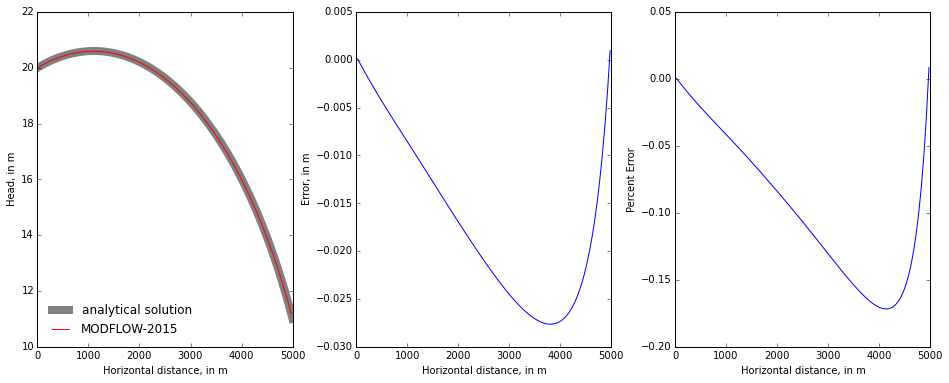

In [6]:
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.25, hspace=0.25)

ax = fig.add_subplot(1, 3, 1)
ax.plot(xa, ha, linewidth=8, color='0.5', label='analytical solution')
ax.plot(x, head[0, 0, :], color='red', label='MODFLOW-2015')
leg = ax.legend(loc='lower left')
leg.draw_frame(False)
ax.set_xlabel('Horizontal distance, in m')
ax.set_ylabel('Head, in m')

ax = fig.add_subplot(1, 3, 2)
ax.plot(x, head[0, 0, :] - hac, linewidth=1, color='blue')
ax.set_xlabel('Horizontal distance, in m')
ax.set_ylabel('Error, in m')

ax = fig.add_subplot(1, 3, 3)
ax.plot(x, 100.*(head[0, 0, :] - hac)/hac, linewidth=1, color='blue')
ax.set_xlabel('Horizontal distance, in m')
ax.set_ylabel('Percent Error')